<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_linear_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#get Times New Roman
import matplotlib.font_manager as fm

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)

plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

torch.__version__

--2026-01-15 12:10:47--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2026-01-15 12:10:47--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.05s   

2026-01-15 12:10:47 (15.4 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

/content/

'2.9.0+cpu'

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


This section defines the target function f, the piecewise transform g, and the transformed function h.

torch.Size([1000, 1000])


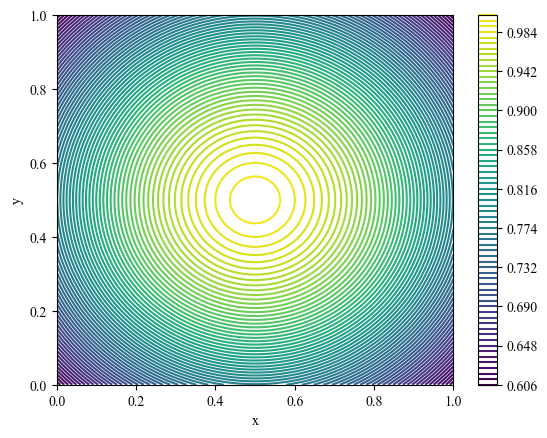

In [19]:
def f(x, y):
  return torch.exp(-((x-0.5)**2 + (y-0.5)**2))

xs, ys = torch.linspace(0, 1, 1000), torch.linspace(0, 1, 1000)

X, Y = torch.meshgrid(xs, ys, indexing='ij')
Z = f(X, Y)
print(Z.shape)
plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
### example parameters ###
D, n, K = 2, 10, 8

In [6]:
#variance test, should be same as Wolfram Alpha
var = torch.var(Z)
print(var)

tensor(0.0077)


In [9]:
def g(x, params):

  '''
  Piecewise-linear transform with K bins, independent in different dimensions.
  Bin widths are equal.
  x.shape = (D, n); params.shape = (2, K-1) where D is dimensions, K is number of bins, n is variable
  "x ---> y"
  '''

  device = x.device
  dtype = x.dtype

  D, n = x.shape
  K = params.size(1) + 1

  #using given params, append 0 and 1 to the ends
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)

  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  y = torch.cat([zeros, params, ones], dim=1)

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d.clamp(min=0, max=K-1))

  i_values = torch.stack(i_values, dim=0)

  # Create row indices as not working in 1D
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, i_values]
  x_right = bins[row_indices, i_values+1]
  y_left = y[row_indices, i_values]
  y_right = y[row_indices, i_values+1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

#testing

x = torch.linspace(0, 1, 1000, device='cpu')
xs = torch.stack((x, x), dim=0)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]], device='cpu')
test = g(xs, params)
print(test.shape)



torch.Size([2, 1000])


In [12]:
def h(y, params):

  '''
  Resulting function when the piecewise warp is applied, in accordance with the change of variables formula.
  Integral should be preserved.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) + 1

  #using given params, append 0 and 1 to the ends
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)

  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  ys = torch.cat([zeros, params, ones], dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], ys[d], right=False) - 1
    j_values.append(j_d.clamp(min=0, max=K-1))

  j_values = torch.stack(j_values, dim=0)

  # Create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values+1]
  y_left = ys[row_indices, j_values]
  y_right = ys[row_indices, j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)
  jac_det = jac.prod(dim=0)

  return f(*arg) * jac_det

#testing
y = torch.linspace(1e-10, 1, 1000)
ys = torch.stack((y, y), dim=0)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]])
test_h = h(ys, params)
print(test_h.shape)

torch.Size([1000])


Here is a plot of h with arbitrary parameters, which it would be worthwhile to functionalise at some point.

torch.Size([2, 1000000])
torch.Size([1000000])


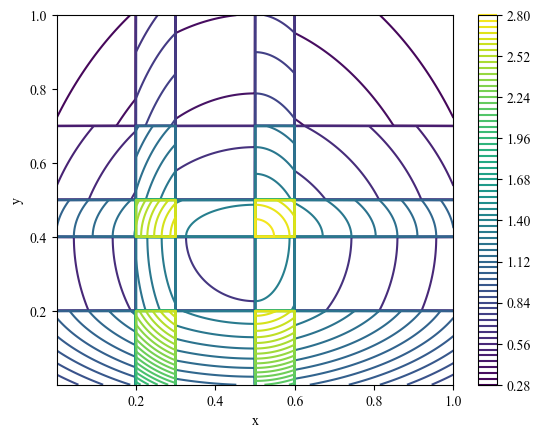

In [ ]:
#testing plot of h (not optimised)

xs, ys = torch.linspace(1e-10, 1, 1000), torch.linspace(1e-10, 1, 1000)
X, Y = torch.meshgrid(xs, ys, indexing='ij')
points = torch.stack([X.flatten(), Y.flatten()], dim=0)
print(points.shape)
h_test = h(points, params)
print(h_test.shape)
Z = h_test.view(1000, 1000)

plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


This section checks that the integral of the function is preserved under the transformation, and checks that the variances are sensible.

In [17]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.851121###
N = 100000
#torch.manual_seed(42)
test_params = params

def MC_F(N):
  x, y = torch.rand(N), torch.rand(N)
  f_evals = f(x, y)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params):
  y1, y2 = torch.rand(N), torch.rand(N)
  y = torch.stack((y1, y2), dim=0)
  h_evals = h(y, params)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params)
print(f'H estimate = {H_est} ± {alpha_H}')


#can histogram results if needed

F estimate = 0.8508042097091675 ± 0.0002774170716293156
H estimate = 0.849685788154602 ± 0.0016850789543241262


In [18]:
#check that variances are different in general
x_test, y_test = torch.rand(N), torch.rand(N)
y = torch.stack((x_test, y_test), dim=0)

f_var = torch.var(f(x_test, y_test))

h_for_var = h(y, test_params)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0077)
H variance: tensor(0.2849)


This section adds the use of unconstrained parameters by defining a softmax function to make varying K easier.  The training loop for minimising the variance is defined and a test plot of h is made for some optimised parameters.

In [20]:
#unconstrained parameters (makes varying K easier)
import torch.nn.functional
def u_to_y(u):

  device = u.device
  dtype = u.dtype

  zeros = torch.zeros((u.size(0), 1), device=device, dtype=dtype)
  u_ext = torch.cat([u, zeros], dim=1)
  w = torch.nn.functional.softmax(u_ext, dim=1)
  ys = torch.cumsum(w, dim=1)
  return ys[:, :-1]


In [24]:
#optimisation

#can use a training loop, variance is the loss function

def train_loop(x, K, epochs, lr, device, ticker):
  '''
  x.shape = (D, n); K bins, D dimensions
  '''

  if device is None:
    device = x.device

  D = x.size(0)
  u_params = torch.zeros((D, K-1), device=device, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  loss_values = torch.zeros(epochs, device=device)

  for epoch in range(epochs):
    params = u_to_y(u_params)
    g_ev = g(x, params)
    h_eval = h(g_ev, params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if ticker == True:
      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

  return loss, loss_values, u_to_y(u_params)

x_test = torch.rand(2, 1000)
test = train_loop(x_test, 16, 180, lr=0.05, device=device, ticker=False)
print(test[0].item())

0.00015222429647110403


In [25]:
#plot of h with optimised parameters

def h_plot(params, N, levels):

  '''
  NB requires matplotlib.ticker to have been imported
  '''

  ys = torch.linspace(1e-10, 1, N, device=params.device)
  Y1, Y2 = torch.meshgrid(ys, ys, indexing='xy')
  y = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(y, params)

  Z = h_eval.view(N, N).cpu()


  fig, ax = plt.subplots(figsize=(8,6))

  contour_plot = ax.contour(Y1.cpu(), Y2.cpu(), Z, levels=levels, cmap='viridis')

  ax.set_xlabel("$y_1$", fontsize=19)
  ax.set_ylabel("$y_2$", fontsize=19)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  ##legend decimal places##
  cbar = plt.colorbar(contour_plot, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.4f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()

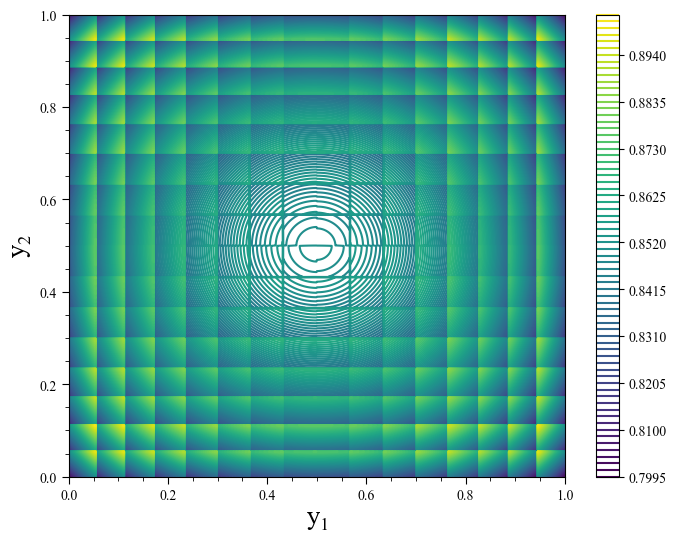

In [28]:
opt_params = test[2].detach().cpu()
h_plot(opt_params, 1000, 75)

This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.

Loss vs epoch for different K

In [29]:
#generate data

device = x_test.device
dtype = x_test.dtype

K_s = [2, 4, 8, 16, 32, 64]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

for i in range(len(K_s)):
  loss_values[i] = train_loop(x_test, K_s[i], epochs, lr=0.05, device=device, ticker=False)[1]

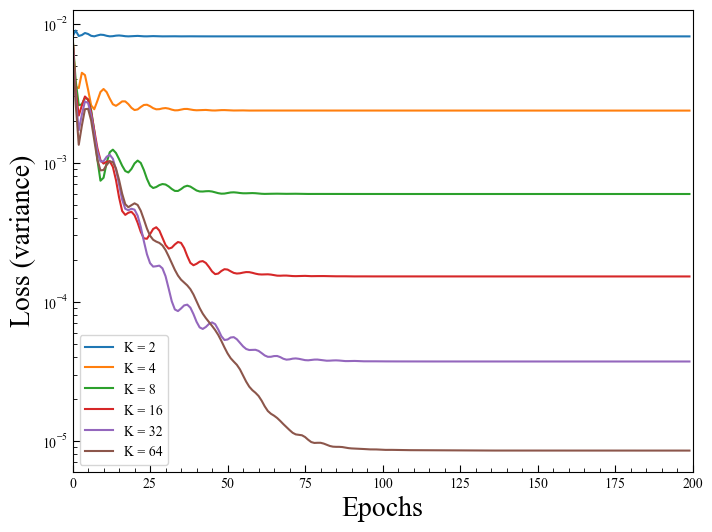

In [30]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

epochs_plot = torch.arange(epochs)
for i in range(len(K_s)):
  ax.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'K = {K_s[i]}')

ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Loss (variance)", fontsize=20)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 200)

plt.legend()
plt.yscale('log')
plt.show()

Loss vs K

In [31]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks), device=device)
i=0

for K in Ks:
  result = train_loop(x_test, K, epochs=200, lr=0.05, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

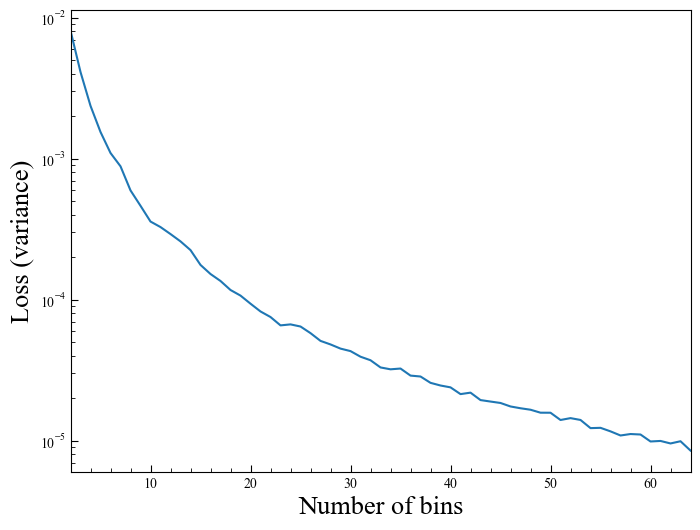

tensor(8.5152e-06, grad_fn=<SelectBackward0>)


In [33]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ks, vars.detach().numpy())  # Detach and convert to numpy for plotting

ax.set_xlabel("Number of bins", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(2, 64)
plt.yscale('log')
plt.show()
print(vars[-1])     #check accuracy

Loss vs epoch for different learning rates

In [34]:
#generate data

K = 16
l_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs), device=device)

for i in range(len(l_rates)):
  loss_values[i] = train_loop(x_test, K, epochs, lr=l_rates[i], device=device, ticker=False)[1]

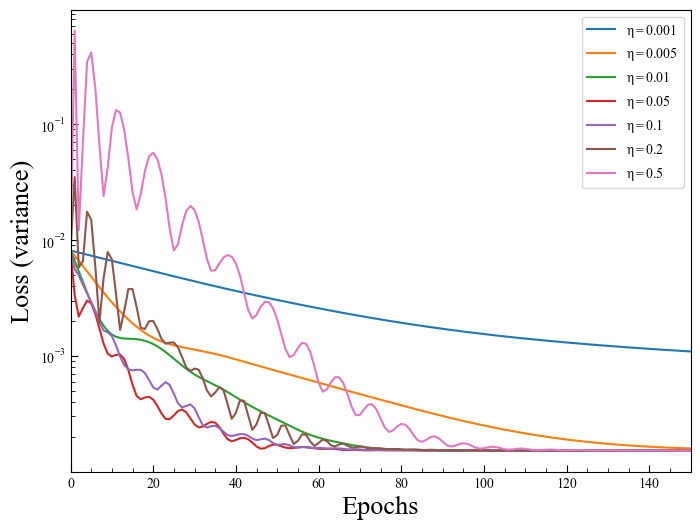

In [36]:
#plotting

fig, ax = plt.subplots(figsize=(8, 6))

epochs_plot = torch.arange(epochs, device='cpu')
for i in range(len(l_rates)):
  ax.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=rf"$\eta = {l_rates[i]}$")

ax.set_xlabel("Epochs", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 150)

plt.legend()
plt.yscale('log')
plt.show()